# Flocking

Create simulation and animation

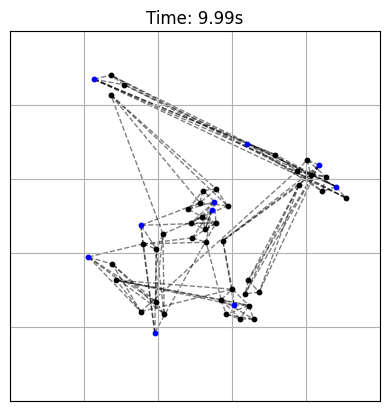

In [1]:
import numpy as np
import torch
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parameters
dim = 2
x_min, x_max = 0, 100
y_min, y_max = 0, 100
max_velocity = 5.0
sigma_x, sigma_y = 0.1, 0.1
k_repulsive = 1000.0

dist_align = 20.0
dist_cohere = 20.0
dist_safe = 5.00

dt = 1e-2
time_horizon = 10
num_time_steps = int(time_horizon / dt)

graph_seed = 29
num_nodes = 50
num_leaders = 10
num_neighbors = 4
separation_weight, alignment_weight, cohesion_weight, leader_weight = 0.8, 0.05, 0.05, 0.1

# Initialize random seed and positions
np.random.seed(graph_seed)
X = np.array([(x_max - x_min), (y_max - y_min)]) * np.random.rand(num_nodes, dim) + np.array([x_min, y_min])
adj_matrix = kneighbors_graph(X, n_neighbors=num_neighbors, mode='connectivity', include_self=False)
graph = nx.from_scipy_sparse_array(adj_matrix)

class Agent:
    def __init__(self, x, y, vx, vy, is_leader=False, target=None):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.pos = torch.tensor([x, y], dtype=torch.float)
        self.is_leader = is_leader
        self.target = target

    def dist(self, other):
        return np.linalg.norm([self.x - other.x, self.y - other.y])

def potential_function(dist, dist_safe, epsilon=1e-3):
    if dist < dist_safe:
        return 0.5*k_repulsive * (1/(dist+epsilon) - 1/(dist_safe+epsilon))**2
    else:
        return 0

def separation(node, dist_safe, epsilon=1e-3):
    agent = agents[node]
    neighbors = [a for a in agents if agent.dist(a) < dist_safe]
    if not neighbors:
        return 0, 0
    sum_fx, sum_fy = 0, 0
    for neighbor in neighbors:
        diff_x, diff_y = agent.x - neighbor.x, agent.y - neighbor.y
        dist = np.linalg.norm(np.array([diff_x, diff_y]))
        force_magnitude = potential_function(dist, dist_safe)
        sum_fx += force_magnitude * diff_x/(dist + epsilon)
        sum_fy += force_magnitude * diff_y/(dist + epsilon)
    return 1/len(neighbors)*sum_fx, 1/len(neighbors)*sum_fy

def alignment(node, graph):
    agent = agents[node]
    neighbors = [agents[i] for i in graph.nodes()]
    if not neighbors or agent.is_leader:
        return 0, 0
    sum_vx, sum_vy = 0, 0
    for neighbor in neighbors:
        sum_vx += neighbor.vx
        sum_vy += neighbor.vy
    return sum_vx / len(neighbors), sum_vy / len(neighbors)

def cohesion(node, graph):
    agent = agents[node]
    neighbors = [agents[i] for i in graph.neighbors(node) if agent.dist(agents[i]) < dist_cohere]
    if not neighbors or agent.is_leader:
        return 0, 0
    sum_x, sum_y = 0, 0
    for neighbor in neighbors:
        sum_x += neighbor.x
        sum_y += neighbor.y
    avg_x = sum_x / len(neighbors)
    avg_y = sum_y / len(neighbors)
    return avg_x - agent.x, avg_y - agent.y

def leader_follower(node, agents):
    agent = agents[node]
    if agent.is_leader:
        return agent.target[0] - agent.x, agent.target[1] - agent.y
    else:
        if not agent.is_leader:
            nearest_leader = min(agents[:num_leaders], key=lambda a: agent.dist(a))
            return nearest_leader.x - agent.x, nearest_leader.y - agent.y
        else:
            return 0, 0

# Initialize agents
agents = []
for i in range(num_nodes):
    x, y = X[i]
    vx, vy = np.random.rand(2) * max_velocity
    is_leader = i < num_leaders
    if is_leader:
        target = np.array([np.random.uniform(x_min, x_max),
                           np.random.uniform(y_min,y_max)])
        vx, vy = (target - X[i]) / np.linalg.norm(target - X[i])*dt
    else:
        target = None
    agent = Agent(x, y, vx, vy, is_leader=is_leader, target=target)
    agents.append(agent)

# Simulation
tt = np.linspace(0, time_horizon, num_time_steps)
X_traj = np.zeros((num_nodes, num_time_steps, dim))

for step, t in enumerate(tt):
    for i in range(num_nodes):
        agent = agents[i]
        X_traj[i, step] = np.array([agent.x, agent.y])
        sep_x, sep_y = separation(i, dist_safe)
        ali_x, ali_y = alignment(i, graph)
        coh_x, coh_y = cohesion(i, graph)
        lead_x, lead_y = leader_follower(i, agents)
        agent.vx += separation_weight * sep_x + alignment_weight * ali_x + cohesion_weight * coh_x + leader_weight * lead_x
        agent.vy += separation_weight * sep_y + alignment_weight * ali_y + cohesion_weight * coh_y + leader_weight * lead_y
        agent.vx, agent.vy = np.clip([agent.vx, agent.vy], -max_velocity, max_velocity)
        agent.x +=  agent.vx * dt
        agent.y +=  agent.vy * dt
       

# Visualization
fig = plt.figure()
ax = plt.axes(xlim=(0, 100), ylim=(0, 100))

def animate(step):
    ax.clear()
    pos = {i: X_traj[i, step] for i in range(num_nodes)}
    nx.draw_networkx_nodes(graph, pos, nodelist=[i for i in range(num_nodes) if agents[i].is_leader], node_color='blue', node_size=10)
    nx.draw_networkx_nodes(graph, pos, nodelist=[i for i in range(num_nodes) if not agents[i].is_leader], node_color='black', node_size=10)
    nx.draw_networkx_edges(graph, pos, edge_color='black', alpha=0.5, style='dashed')
    ax.grid(True)
    ax.set_aspect('equal')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f'Time: {step * dt:.2f}s')

ani = animation.FuncAnimation(fig, animate, frames=num_time_steps, interval=10)
ani.save(f'plots/flocking.mp4', writer='ffmpeg', dpi=300, fps=30)
plt.show()